In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from yellowbrick.classifier import ClassificationReport

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 55)

In [3]:
#read in csv
df = pd.read_csv("bigtable.csv")

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]#.astype(np.float64)

df = pd.read_csv("bigtable.csv")
df = clean_dataset(df).reset_index()

features = df[[
    'population', 
    'dist-mroads', 
    'dist-setl', 
    'dist-coast', 
    'dist-forest', 
    'slope', 
    'elevation', 
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

numericColumns = ['population', 'dist-mroads', 'dist-setl', 'dist-coast', 'dist-forest', 'slope', 'elevation',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'VIS',  'ATM'
    ]
categoricalColumns = ['dayofweek']

gs = df[['station_id']]

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology
    'AQI_class'  #pm25 transformed into EPA categorical class
]]

labels.loc[:,"polluted"] = (labels.loc[:,"AQI_class"] != "Good")

y=labels["polluted"]
X=features
X['dayofweek']

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0        2.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
97669    6.0
97670    6.0
97671    6.0
97672    6.0
97673    6.0
Name: dayofweek, Length: 97674, dtype: category
Categories (7, float64): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [5]:
dict(features.dtypes)

{'population': dtype('float64'),
 'dist-mroads': dtype('float64'),
 'dist-setl': dtype('float64'),
 'dist-coast': dtype('float64'),
 'dist-forest': dtype('float64'),
 'slope': dtype('float64'),
 'elevation': dtype('float64'),
 'dayofweek': CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
 'sin_day': dtype('float64'),
 'cos_day': dtype('float64'),
 'sin_year': dtype('float64'),
 'cos_year': dtype('float64'),
 'TEMP': dtype('float64'),
 'cos_wind': dtype('float64'),
 'sin_wind': dtype('float64'),
 'Wind-Rate': dtype('float64'),
 'DEW': dtype('float64'),
 'SKY': dtype('float64'),
 'VIS': dtype('float64'),
 'ATM': dtype('float64')}

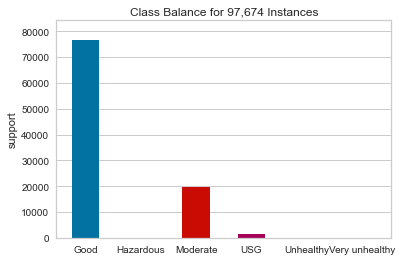

In [6]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(
    #labels=["Good", "USG", "Moderate", "Unhealthy", "Very unhealthy", "Hazardous"], size=(1080, 720)
)

visualizer.fit(df['AQI_class'].values)
visualizer.show()

In [7]:
df['AQI_class'].value_counts()


Good              76598
Moderate          19674
USG                1308
Unhealthy            80
Hazardous             9
Very unhealthy        5
Name: AQI_class, dtype: int64

In [8]:
correlations = df.corr(method='pearson')
print(correlations)

                index      pm25         x         y  population  dist-mroads  \
index        1.000000 -0.253985  0.186806 -0.028724   -0.396077     0.088765   
pm25        -0.253985  1.000000 -0.089321  0.025894    0.132410    -0.071573   
x            0.186806 -0.089321  1.000000  0.213115   -0.094125     0.545459   
y           -0.028724  0.025894  0.213115  1.000000   -0.357685     0.422888   
population  -0.396077  0.132410 -0.094125 -0.357685    1.000000    -0.388944   
dist-mroads  0.088765 -0.071573  0.545459  0.422888   -0.388944     1.000000   
dist-setl    0.620652 -0.226481  0.366705  0.169450   -0.523882     0.638220   
dist-coast   0.411249 -0.182060  0.829367  0.222849   -0.277483     0.695127   
dist-forest -0.674291  0.242349 -0.284170 -0.063112    0.415623    -0.549514   
slope        0.063604 -0.010794 -0.546752 -0.445750    0.316722    -0.201388   
elevation   -0.148030 -0.012237  0.265302 -0.363901    0.410930     0.355187   
dayofweek   -0.006602  0.036812  0.00401

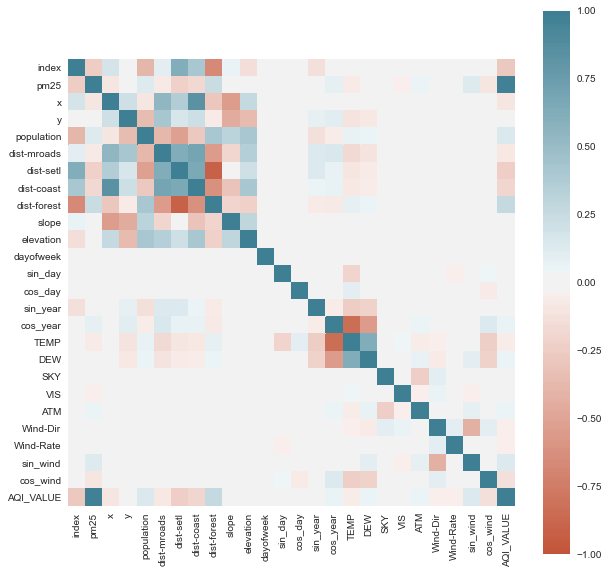

In [9]:
import seaborn as sns

#sns.heatmap(correlations)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
heatM = sns.heatmap(correlations, vmin = -1, vmax = 1,center = 0, cmap = sns.diverging_palette(20, 220, n = 200),  square = True, annot = False) 

#heatM.set_ylim([10,0]) # number of features Limit

In [10]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
    
# We create the preprocessing pipelines for both numeric and categorical data.
#numeric_features = numericColumns
#@todo imputer

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#categorical_features = categoricalColumns

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])



In [11]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])),
     ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [12]:
# Try them all! Looking for Pokemons

models = [
    SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier()
]


for model in models:
    score_model(X, y, model)

SVC: 0.5978043912175649
KNeighborsClassifier: 0.8062058526740666
LogisticRegression: 0.3253375915576075
BaggingClassifier: 0.9529051402316454
ExtraTreesClassifier: 0.9559875162804414
RandomForestClassifier: 0.9569871825644471
DecisionTreeClassifier: 0.9559875162804414


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


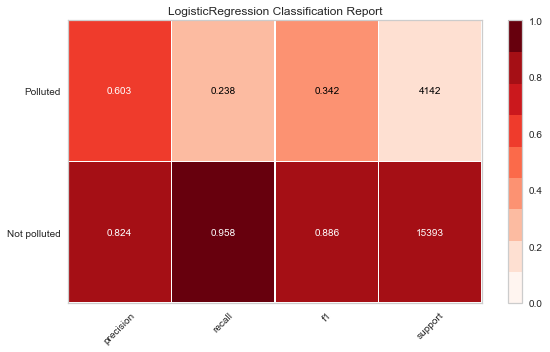

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


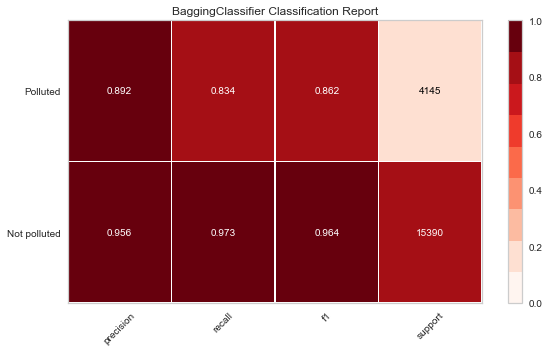

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


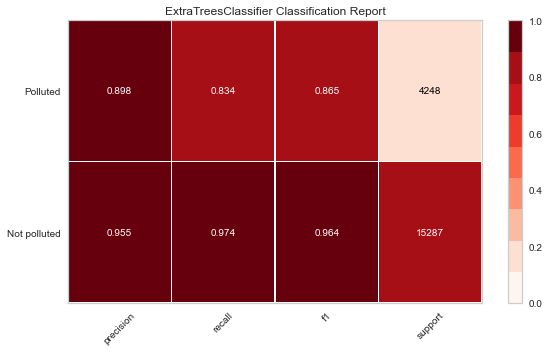

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


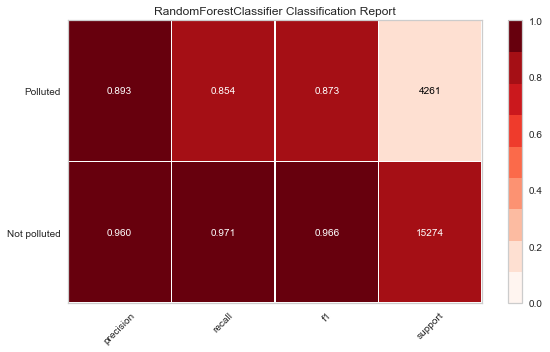

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


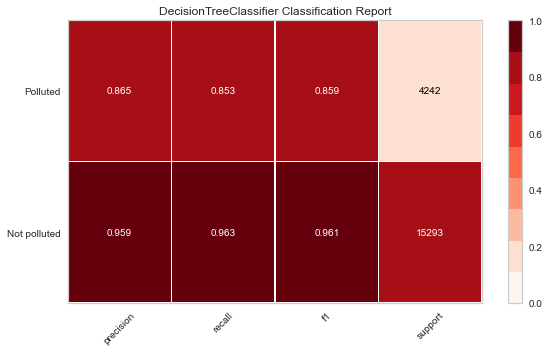

In [13]:
  
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ("preprocessor", ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])),
     ('estimator', estimator)
    ])
    
    visualizer = ClassificationReport(
        model, 
        classes=['Not polluted', 'Polluted'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)
    
    visualizer.score(X_test, y_test)
    
    visualizer.show()
    
    return visualizer.scores_
  

    
#keeping best ones
models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier()
]

for model in models:
    s = visualize_model(X, y, model)

    


In [14]:
s

{'precision': {'Not polluted': 0.9594841063053674,
  'Polluted': 0.8654076021993784},
 'recall': {'Not polluted': 0.9631857712679004,
  'Polluted': 0.8533710513908533},
 'f1': {'Not polluted': 0.9613313754282917, 'Polluted': 0.8593471810089021},
 'support': {'Not polluted': 0.7828512925518301,
  'Polluted': 0.21714870744816994}}

# To avoid or detect overfitting to groundstations conditions (too few ground stations)

Let s shuffle Training and test data based on Groundstations id

Only 13 stations, so let's use 10 for training and 3 for testing.


Substations selected for testing are : 
['Cheverly 9', 'McMillan 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


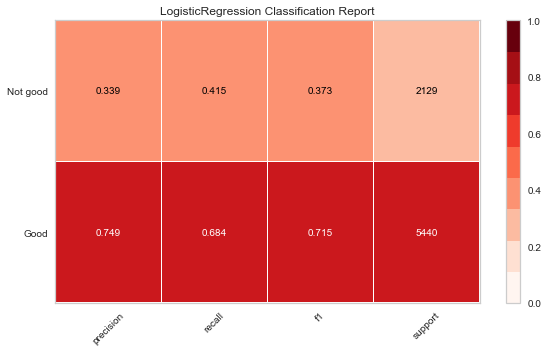

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


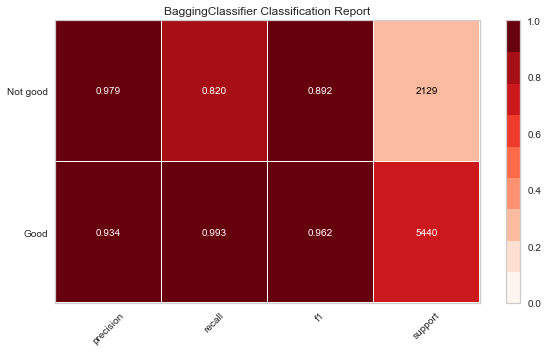

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


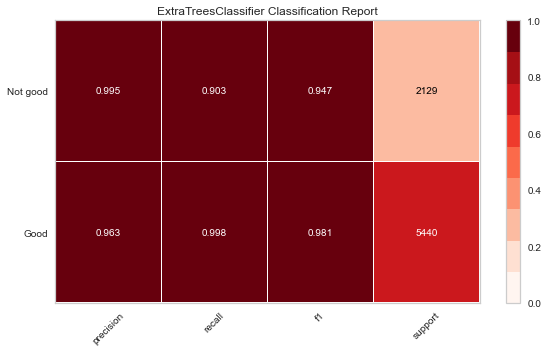

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


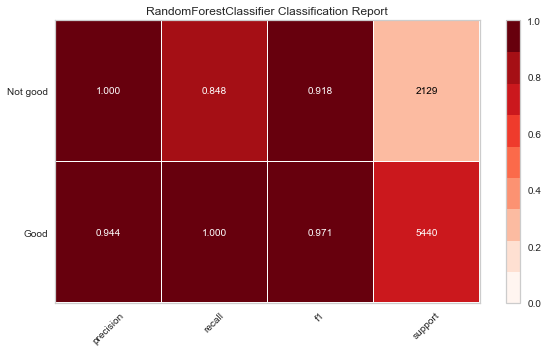

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


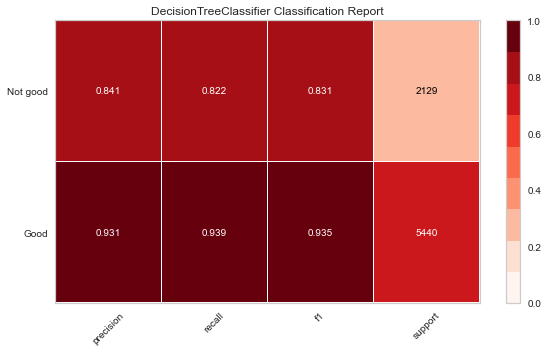

In [15]:
import random

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Substations selected for testing are : ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters]


def visualize_model_gs(X_train, X_test, y_train, y_test, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)
    
    model = Pipeline([
     ("ColumnTransformer", ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])),
     ('estimator', estimator)
    ])


    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Good', 'Not good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    #X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    #import pdb; pdb.set_trace()
    visualizer.fit(X_train, y_train)  
    score = visualizer.score(X_test, y_test)
    visualizer.show()
    return visualizer.scores_

X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    s= visualize_model_gs(X_train, X_test, y_train, y_test, model)

In [16]:
#Remove all x/y features and keep just "postion in decimal degrees"
#We consider a dimension reduction from location dependant features inside X and Y
#Make also possible to predict in one step the pollution
#That, s not optimal for having good prediction because GIS feature are the most related to our AQI value
# location + weather --> air qual
# versus Location --> GIS variable + weather --> Air Qual
features_noGIS = df[[
    'x',
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

numericColumns = ['x','y',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'VIS',  'ATM'
    ]
categoricalColumns = ['dayofweek']

#features_noGIS.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

X=features_noGIS
#numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
#categorical_features = X.select_dtypes(include=['object']).columns


models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier()
]

Substations selected for testing are : 
['MA_EPA', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


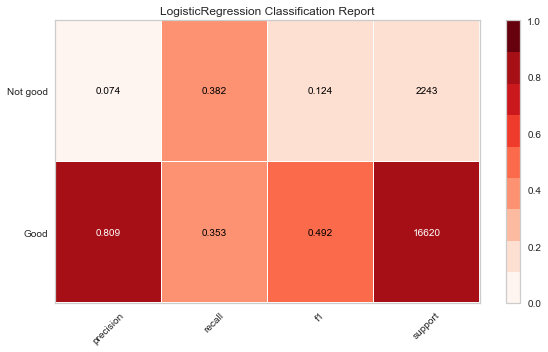

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


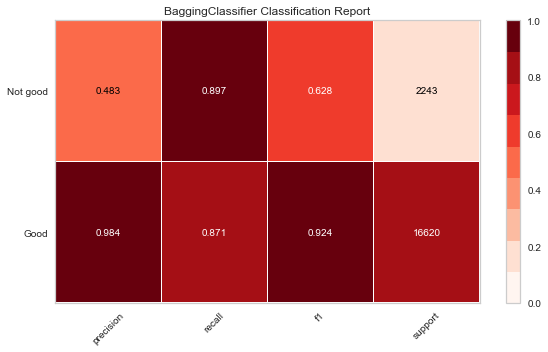

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


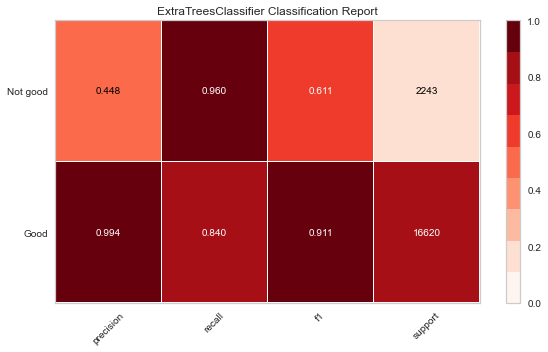

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


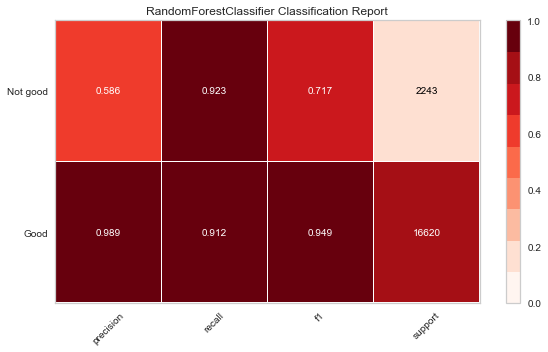

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


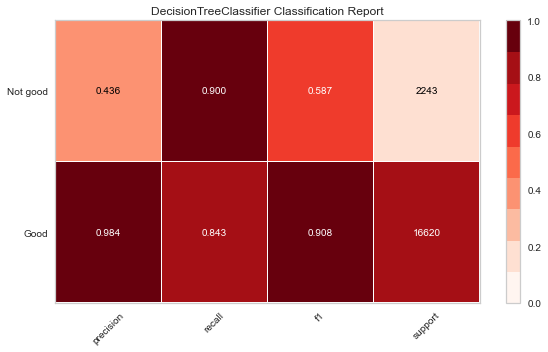

In [17]:
X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    visualize_model_gs(X_train, X_test, y_train, y_test, model)

In [18]:
s

{'precision': {'Good': 0.9310973386802771, 'Not good': 0.8406144983197311},
 'recall': {'Good': 0.9389705882352941, 'Not good': 0.8224518553311414},
 'f1': {'Good': 0.9350173897126122, 'Not good': 0.8314339981006647},
 'support': {'Good': 0.7187210992205046, 'Not good': 0.2812789007794953}}

Test substations selected: 
['Arlington', 'DC_EPA', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


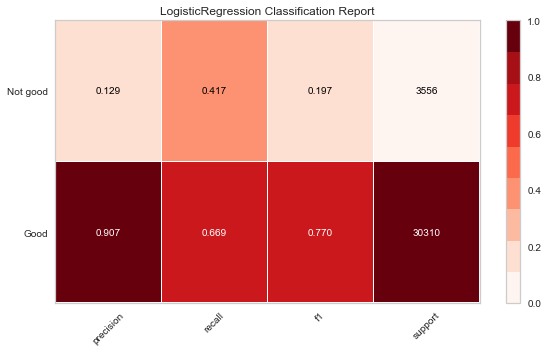

 > Score 0.19678661532333022
Test substations selected: 
['13th & E ST SE B', 'McMillan 1', 'Cheverly 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


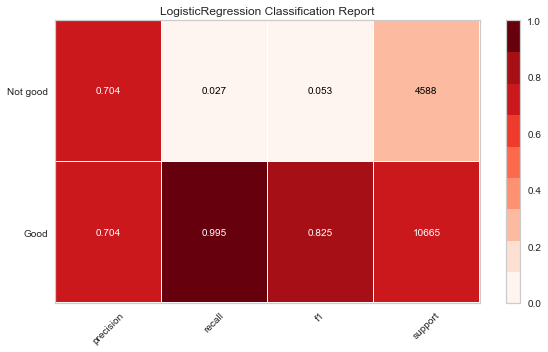

 > Score 0.05286343612334802
Test substations selected: 
['14th & S ST NW B', '13th & E ST SE A', 'MA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


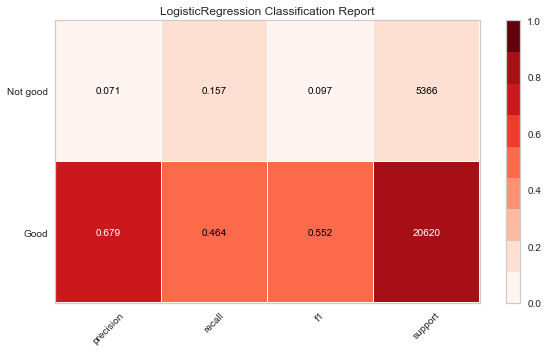

 > Score 0.09738565880238827
Test substations selected: 
['Courthouse', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


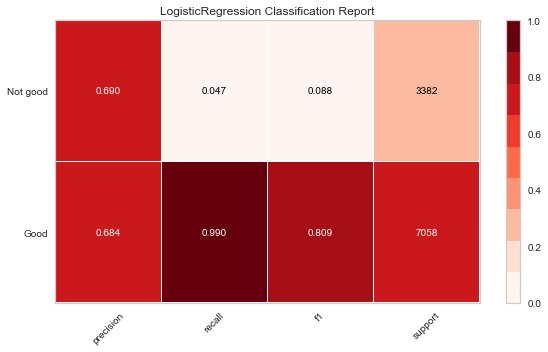

 > Score 0.08751038493492108
Test substations selected: 
['V Street', '14th & S ST NW A']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


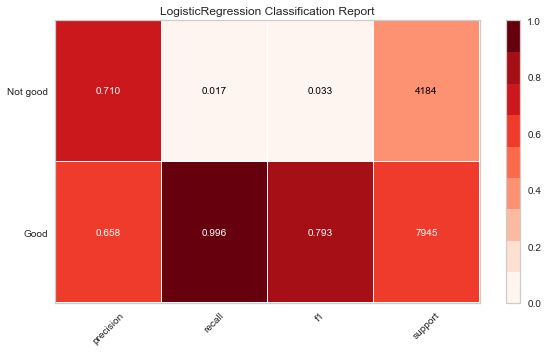

 > Score 0.03314659197012138
 >> Mean score 0.09353853743082179
['LogisticRegression', 0.19678661532333022, 0.05286343612334802, 0.09738565880238827, 0.08751038493492108, 0.03314659197012138, 0.0032025910993520707, 0.09353853743082179]
Test substations selected: 
['Arlington', 'DC_EPA', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


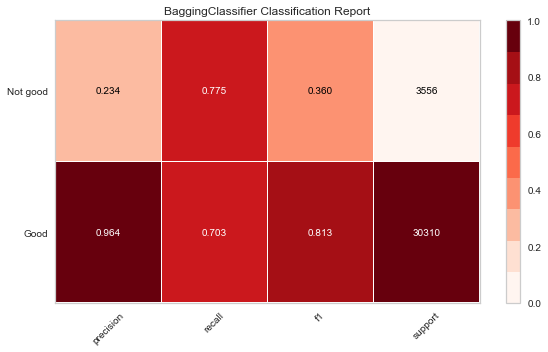

 > Score 0.3598746899882522
Test substations selected: 
['13th & E ST SE B', 'McMillan 1', 'Cheverly 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


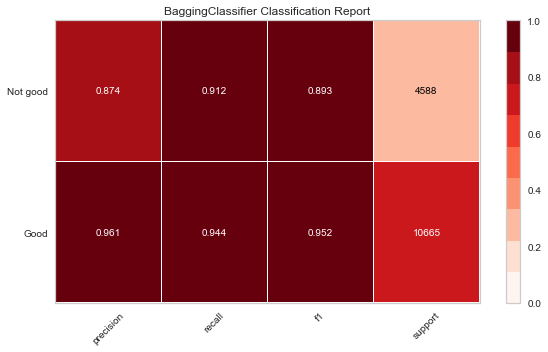

 > Score 0.8928952421591637
Test substations selected: 
['14th & S ST NW B', '13th & E ST SE A', 'MA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


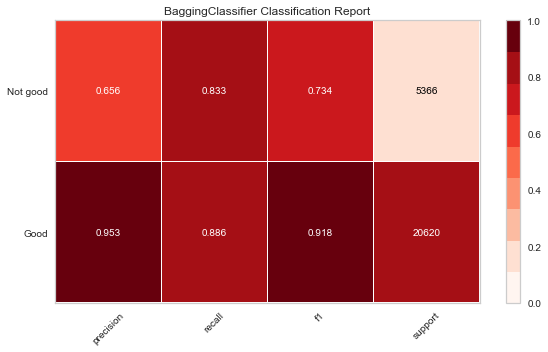

 > Score 0.7336889618383259
Test substations selected: 
['Courthouse', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


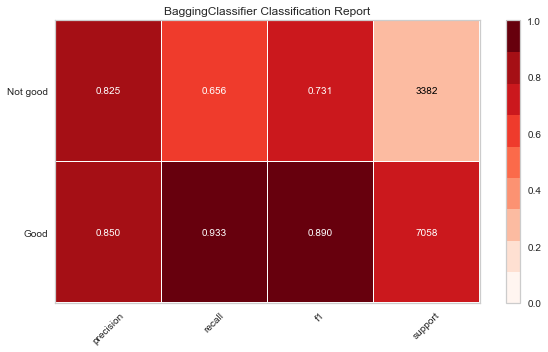

 > Score 0.7311048904989297
Test substations selected: 
['V Street', '14th & S ST NW A']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


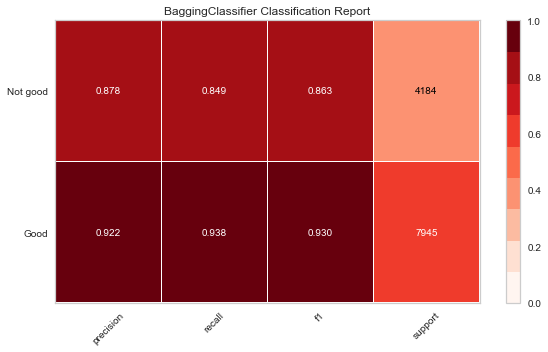

 > Score 0.8630453275003037
 >> Mean score 0.716121822396995
['BaggingClassifier', 0.3598746899882522, 0.8928952421591637, 0.7336889618383259, 0.7311048904989297, 0.8630453275003037, 0.036056094870720916, 0.716121822396995]
Test substations selected: 
['Arlington', 'DC_EPA', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


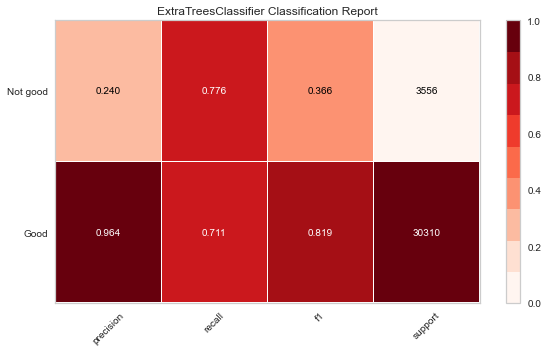

 > Score 0.3664963164531758
Test substations selected: 
['13th & E ST SE B', 'McMillan 1', 'Cheverly 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


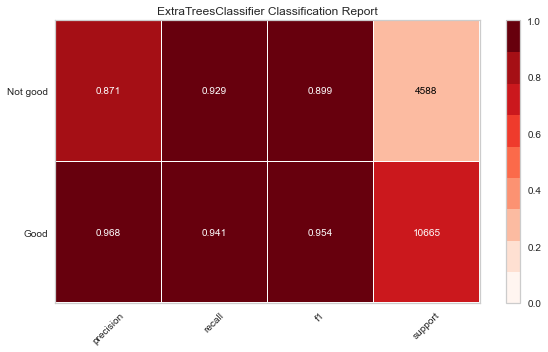

 > Score 0.8987555368065809
Test substations selected: 
['14th & S ST NW B', '13th & E ST SE A', 'MA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


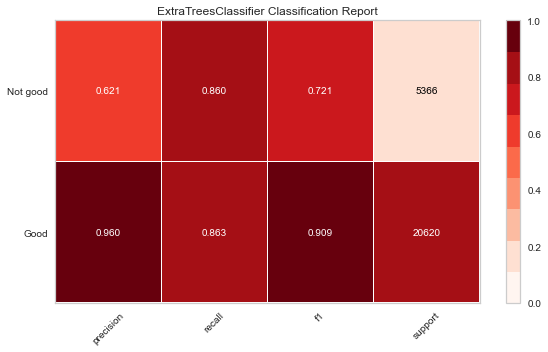

 > Score 0.7210374189516443
Test substations selected: 
['Courthouse', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


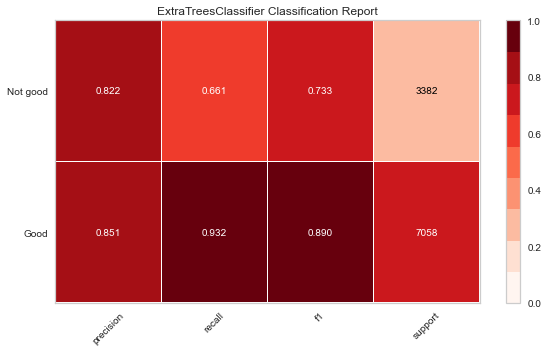

 > Score 0.7325791113297261
Test substations selected: 
['V Street', '14th & S ST NW A']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


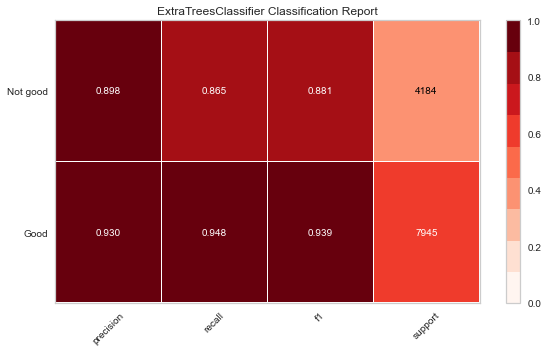

 > Score 0.8812857664677949
 >> Mean score 0.7200308300017845
['ExtraTreesClassifier', 0.3664963164531758, 0.8987555368065809, 0.7210374189516443, 0.7325791113297261, 0.8812857664677949, 0.0366181600425536, 0.7200308300017845]
Test substations selected: 
['Arlington', 'DC_EPA', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


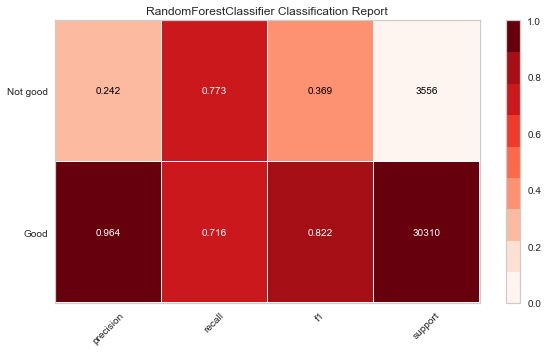

 > Score 0.36897893465718506
Test substations selected: 
['13th & E ST SE B', 'McMillan 1', 'Cheverly 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


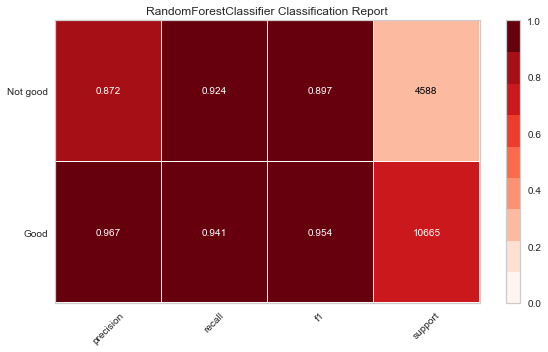

 > Score 0.8971646212441811
Test substations selected: 
['14th & S ST NW B', '13th & E ST SE A', 'MA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


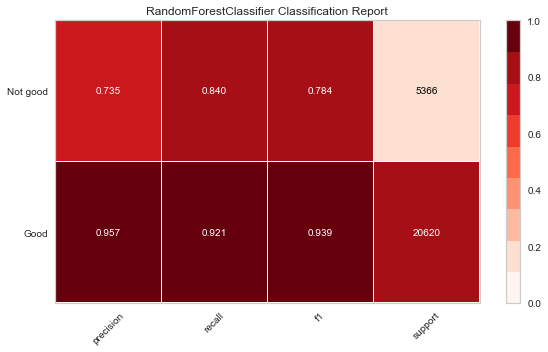

 > Score 0.7840069534984789
Test substations selected: 
['Courthouse', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


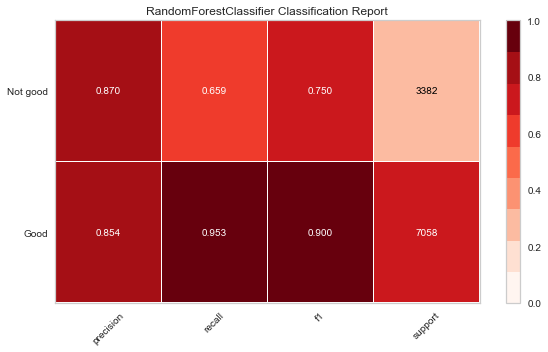

 > Score 0.7500840901446351
Test substations selected: 
['V Street', '14th & S ST NW A']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


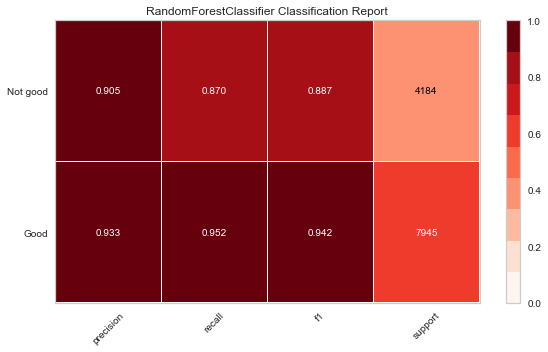

 > Score 0.8870476422566101
 >> Mean score 0.737456448360218
['RandomForestClassifier', 0.36897893465718506, 0.8971646212441811, 0.7840069534984789, 0.7500840901446351, 0.8870476422566101, 0.03719726214954269, 0.737456448360218]
Test substations selected: 
['Arlington', 'DC_EPA', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


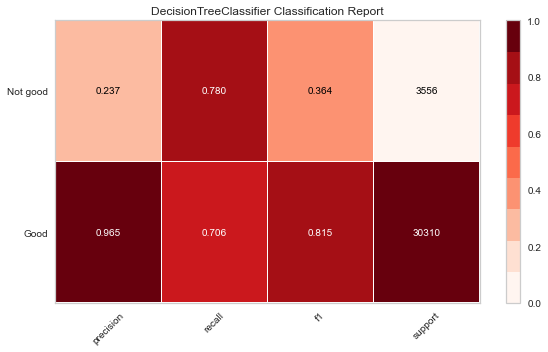

 > Score 0.36399422647946467
Test substations selected: 
['13th & E ST SE B', 'McMillan 1', 'Cheverly 1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


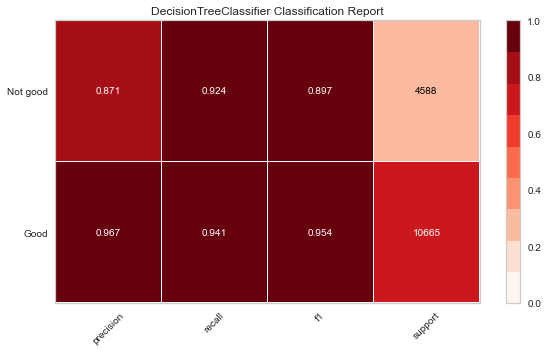

 > Score 0.8969966159052453
Test substations selected: 
['14th & S ST NW B', '13th & E ST SE A', 'MA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


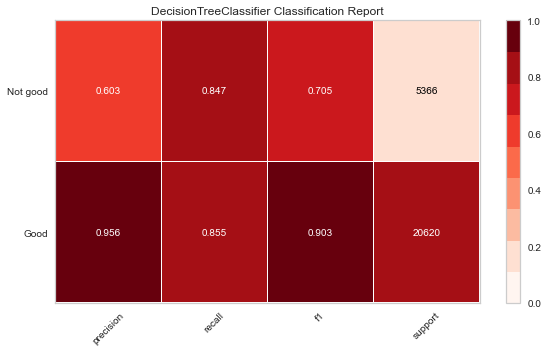

 > Score 0.7047515696457639
Test substations selected: 
['Courthouse', 'Cheverly 9']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


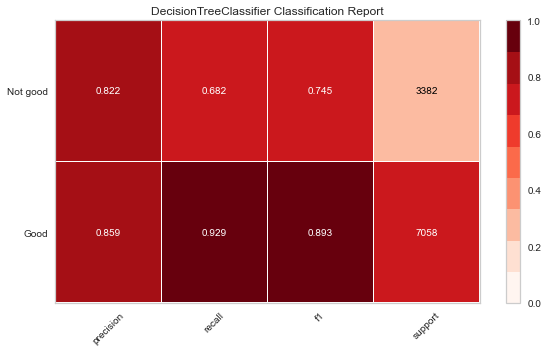

 > Score 0.7453516572352464
Test substations selected: 
['V Street', '14th & S ST NW A']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


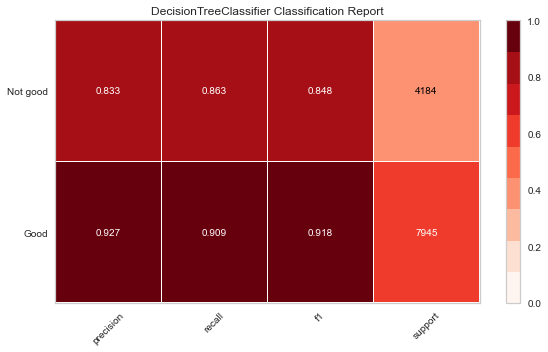

 > Score 0.8476883360713448
 >> Mean score 0.7117564810674131
['DecisionTreeClassifier', 0.36399422647946467, 0.8969966159052453, 0.7047515696457639, 0.7453516572352464, 0.8476883360713448, 0.034981533424282826, 0.7117564810674131]


In [19]:
import random

X=features_noGIS
y=labels["polluted"]


def tts_grps(X, y, groups):
    filters = gs["station_id"].isin(groups)
    print('Test substations selected: ')
    print(groups)
    return X[~filters], X[filters], y[~filters], y[filters]
    

stations = list(gs["station_id"].unique())
stations_groups = [[], [], [], [], []]

totStations = len(stations)
for i in range(totStations):
    random_item_from_list = random.choice(stations)
    stations.remove(random_item_from_list)
    stations_groups[i % 5].append(random_item_from_list)

dfScores = pd.DataFrame(
    columns = ['model', 'group1', 'group2', 'group3', 'group4', 'group5', 'Var', 'Mean']
)

for model in models:
    scores = []
    for groups in stations_groups:
        X_train, X_test, y_train, y_test = tts_grps(X, y, groups)
        scores_ = visualize_model_gs(X_train, X_test, y_train, y_test, model)
        score = scores_['f1']['Not good']
        print(" > Score {}".format(score))
        scores.append(score)
    print(" >> Mean score {}".format(sum(scores) / len(stations_groups)))
    mean = sum(scores) / len(stations_groups)
    scores.append(sum((i - mean) ** 2 for i in scores) / len(scores))
    scores.append(mean)
    scores.insert(0, str(model).split("(")[0])
    print(scores)
    dfScores.loc[len(dfScores)] = scores

In [20]:
dfScores.head(7)

,model,group1,group2,group3,group4,group5,Var,Mean
0,LogisticRegression,0.196787,0.052863,0.097386,0.087510,0.033147,0.003203,0.093539
1,BaggingClassifier,0.359875,0.892895,0.733689,0.731105,0.863045,0.036056,0.716122
2,ExtraTreesClassifier,0.366496,0.898756,0.721037,0.732579,0.881286,0.036618,0.720031
3,RandomForestClassifier,0.368979,0.897165,0.784007,0.750084,0.887048,0.037197,0.737456
4,DecisionTreeClassifier,0.363994,0.896997,0.704752,0.745352,0.847688,0.034982,0.711756


# RandomForestClassifier is the best with a mean score of 0.725582 con Var of 0.025